In [1]:
import sys
import os

# 1. 自动获取当前工作目录并修复路径
root_dir = os.getcwd() 
sys.path.append(root_dir)

# 强制映射父目录以解决 Data_processing.py 内部的导入冲突
parent_dir = os.path.dirname(root_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# 2. 显式导入所有必要的 PyTorch 组件
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader  # <--- 修复 NameError 的关键
from torch.cuda.amp import GradScaler
from tqdm import tqdm

# 3. 模块导入与包名映射补丁
try:
    # 强制将当前文件夹名映射为模块名，处理 Data_processing.py 里的旧路径
    folder_name = os.path.basename(root_dir)
    sys.modules['Whole_heart_segmentation_junzhe'] = __import__(folder_name)
    
    import functions_collection as ff
    import Data_processing
    from Build_lists.Build_list import Build 
    import data_loader.random_aug as randaug
    import data_loader.generator as generator
    import segment_anything.model as model
    print("✅ 环境初始化完成，所有模块及 DataLoader 已就绪。")
except Exception as e:
    print(f"⚠️ 导入提醒: {e}")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
✅ 环境初始化完成，所有模块及 DataLoader 已就绪。


### step 1: define trial name

In [2]:
trial_name = 'trial'

### step 2: build patient list

In [3]:
# ==========================================
# 单元格 3：路径自动修正与列表构建
# ==========================================
# 1. 自动获取当前笔记本所在的根目录
root_dir = os.getcwd() 

# 2. 定义 Excel 路径
patient_list_spreadsheet = os.path.join(root_dir, 'example_data/Patient_list', 'patient_list.xlsx')

def fix_spreadsheet_paths(file_path, target_root):
    """
    读取 Excel 并将硬编码的 D 盘路径替换为当前的本地路径
    """
    if os.path.exists(file_path):
        df = pd.read_excel(file_path)
        # 识别旧路径前缀
        old_prefix = '/host/d/GitHub/Whole_heart_segmentation_junzhe/'
        new_prefix = target_root + '/'
        
        # 对所有字符串列进行批量替换
        df = df.replace(old_prefix, new_prefix, regex=True)
        df.to_excel(file_path, index=False)
        print(f"✅ 已自动将 {os.path.basename(file_path)} 中的路径修正为本地 C 盘路径。")

# 执行修正
fix_spreadsheet_paths(patient_list_spreadsheet, root_dir)

# 3. 重新构建列表
build_sheet = Build(patient_list_spreadsheet)
_, patient_id_list_train, slice_index_list_train, img_file_list_train, seg_file_list_train = build_sheet.__build__(batch_list=[0])

print(f"验证第一个文件路径: {img_file_list_train[0]}")
# 此时输出应以 /host/c/Users/Junzhe/... 开头

✅ 已自动将 patient_list.xlsx 中的路径修正为本地 C 盘路径。
验证第一个文件路径: /host/c/Users/Junzhe/Desktop/Whole_heart_segmentation/GitHub/Whole_heart_segmentation_junzhe/example_data/data/ID_0002/img/slice_0.nii.gz


### data generator

In [4]:
# define this generator
generator_train = generator.Dataset_CMR(
    image_file_list = img_file_list_train,
    
    seg_file_list = seg_file_list_train,

    image_shape = [128,128],
    center_crop_according_to_which_class  = [1], #default: crop according to class 1 (LV)

    shuffle = True,
    image_normalization = True,
    augment = True,
    augment_frequency = 0.1,
    )

In [5]:
ds = generator_train
dl = DataLoader(ds, batch_size = 1, shuffle = False, pin_memory = True, num_workers = 0)# cpu_count())

In [6]:
# build model
import argparse
import os

def get_args_parser( vit_type = "vit_h", original_SAM_weights = None):
    parser = argparse.ArgumentParser('SAM fine-tuning', add_help=True)

    parser.add_argument('--resume', default = original_SAM_weights)

    parser.add_argument('--img_size', default=128, type=int) 

    parser.add_argument('--vit_type', default=vit_type, type=str, choices=[ 'vit_b', 'vit_l', 'vit_h'],)
    
 
    return parser

original_sam = '/host/c/Users/Junzhe/Desktop/Whole_heart_segmentation/Data/SAM_weights/sam_vit_b_01ec64.pth'

args = get_args_parser(vit_type = "vit_b",original_SAM_weights = original_sam)
args = args.parse_args([])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# --- 单元格 6: 验证 Mask Decoder 结构 ---
our_model = model.build_model(args, device)
print(f"--- 改造状态核查 ---")
print(f"分类 Token 数量: {our_model.mask_decoder.num_mask_tokens}") # 应打印 3
print(f"MLP 预测头数量: {len(our_model.mask_decoder.output_hypernetworks_mlps)}") # 应打印 3

# --- 单元格 7: 验证数据加载与输出维度 ---
our_model.to(device)
for batch_data in dl:
    # 修正维度并搬运数据
    batch_data["image"] = batch_data["image"].squeeze(0).to(device)
    
    # 执行前向传播
    output = our_model([batch_data], multimask_output=True)
    
    # 获取掩码维度
    masks_shape = output[0]['masks'].shape
    print(f"--- 推理成功 ---")
    print(f"预测掩码维度: {masks_shape}") 
    # 预期输出: [3, 128, 128] -> 3 代表 LV, Myo, Background
    break


    

✅ 成功加载匹配的权重，跳过了形状不符的输出层。
--- 改造状态核查 ---
分类 Token 数量: 3
MLP 预测头数量: 3
x shape:  torch.Size([3, 1024, 1024])
input images:  torch.Size([1, 3, 1024, 1024])
--- 推理成功 ---
预测掩码维度: torch.Size([1, 3, 128, 128])


In [9]:
output[0]["masks"].shape  # (num_masks, H, W)

torch.Size([1, 3, 128, 128])

In [10]:
# ==========================================
# 单元格 9：推理结果可视化验证 (修复 RuntimeError)
# ==========================================
# 1. 使用 .detach() 剥离梯度
a = output[0]["masks"].detach().cpu().numpy()

print('--- 推理数据统计 ---')
print(f'掩码张量维度: {a.shape}') # 预期: [3, 128, 128]
print(f'像素最大值: {np.max(a):.4f}, 最小值: {np.min(a):.4f}')

# 2. 验证 3 分类逻辑
if a.shape[0] == 3:
    print("✅ 验证成功：输出包含 3 个通道，分别对应 LV、心肌和背景。")
    
    # 可选：简单打印各通道均值，确认各通道均有激活
    for i, label in enumerate(['Background', 'LV Pool', 'Myocardium']):
        print(f"通道 {i} ({label}) 均值激活度: {np.mean(a[i]):.4f}")


--- 推理数据统计 ---
掩码张量维度: (1, 3, 128, 128)
像素最大值: 3.0424, 最小值: -10.0058


定义LOSS函数

In [11]:
# 配置优化器 
trainable_params = filter(lambda p: p.requires_grad, our_model.parameters())
optimizer = optim.AdamW(trainable_params, lr=1e-4, weight_decay=0.01)

In [12]:
#定义 Loss
criterion = torch.nn.CrossEntropyLoss()

In [13]:
#混合精度 Scaler
loss_scaler = GradScaler()

In [14]:
import os
os.makedirs("models/my_trial", exist_ok=True)
print("文件夹创建成功！")

文件夹创建成功！


进行训练

In [ ]:
# -------------------------------------------------------------
# 强制手动定义轮数，不再依赖容易出错的 args
# -------------------------------------------------------------
RUN_EPOCHS = 50   # <--- 我们直接在这里定义，不用管 args 里叫什么了
# -------------------------------------------------------------

# 计算总步数
total_steps = len(dl) * RUN_EPOCHS

print(f" 开始训练... 共 {RUN_EPOCHS} 轮，总计 {total_steps} 步")

our_model.train() # 切换到训练模式

# 创建总进度条
pbar = tqdm(total=total_steps, desc="总体训练进度", unit="step")

for epoch in range(1, RUN_EPOCHS + 1):
    epoch_loss = 0.0
    
    # 内层循环直接遍历 dl
    for step, batch_data in enumerate(dl):
        
        # --- (A) 数据搬运 ---
        images = batch_data["image"].cuda()
        gt_masks = batch_data["mask"].cuda().long().squeeze(1)
        
        batched_input = []
        for i in range(len(images)):
            batched_input.append({
                'image': images[i],
                'original_size': (args.img_size, args.img_size)
            })
            
        # --- (B) 前向传播 ---
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = our_model(batched_input, multimask_output=True)
            pred_masks = torch.stack([o['masks'] for o in outputs]).squeeze(1)
            loss = criterion(pred_masks, gt_masks)
        
        # --- (C) 反向传播 ---
        loss_scaler.scale(loss).backward()
        loss_scaler.step(optimizer)
        loss_scaler.update()
        
        epoch_loss += loss.item()
        
        # 4. 手动更新总进度条
        pbar.update(1) 
        pbar.set_postfix({
            'epoch': f"{epoch}/{RUN_EPOCHS}",
            'loss': f"{loss.item():.4f}"
        })

    # (可选) 打印每轮平均 Loss
    # avg_loss = epoch_loss / len(dl)
    # print(f"Epoch {epoch} 结束 | Avg Loss: {avg_loss:.4f}")
    
    # 保存模型
    if epoch % 5 == 0:
        save_path = os.path.join("models/my_trial", f"model_epoch_{epoch}.pth")
        torch.save(our_model.state_dict(), save_path)

pbar.close()
print("\n 训练全部完成！")

In [15]:
# ==========================================
# 单元格 15：修复后的推理与 BBox 打印
# ==========================================
for batch_data in dl:
    # 提取当前的 Ground Truth Mask
    gt_mask = batch_data["mask"].squeeze().cpu().numpy() # 变为 (128, 128)
    
    # 调用函数，padding 设为 10
    bbox_results = ff.get_tilted_3d_bbox(gt_mask, padding=10)
    
    if bbox_results:
        print(f"✅ BBox 提取成功：{bbox_results['sam_prompt']}")
        # 验证正方形约束
        x1, y1, x2, y2 = bbox_results['sam_prompt']
        print(f"📏 X跨度: {x2-x1}, Y跨度: {y2-y1} (应相等)")
    
    # 接下来的模型推理逻辑...
    break

✅ BBox 提取成功：[21, 19, 107, 105]
📏 X跨度: 86, Y跨度: 86 (应相等)


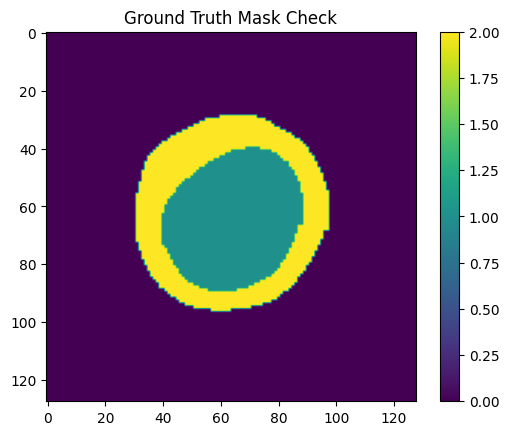

标签中的唯一值 (Unique values in GT): [0. 1. 2.]


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 检查数据是否正确
plt.imshow(gt_mask)
plt.title("Ground Truth Mask Check")
plt.colorbar()
plt.show()

# 验证标签类别是否符合 Task B.1 的 3 分类要求
print(f"标签中的唯一值 (Unique values in GT): {np.unique(gt_mask)}")
# 预期输出应包含 [0. 1. 2.] 分别代表背景、血池和心肌

In [23]:
# ==========================================
# 单元格 22：修复设备冲突并执行推理
# ==========================================
our_model.to(device) # 确保模型在 GPU
our_model.eval()

with torch.no_grad():
    with torch.cuda.amp.autocast():
        # --- 关键修复：搬运数据到 GPU ---
        input_image = batch_data["image"].to(device)
        
        # 处理 BBox 提示词 (Task B.2)
        gt_mask_np = batch_data["mask"].squeeze().cpu().numpy()
        bbox_res = ff.get_tilted_3d_bbox(gt_mask_np, padding=10)
        
        if bbox_res:
            # 同样需要将 box 搬运到 GPU
            box_prompt = torch.tensor(bbox_res['sam_prompt']).to(device).unsqueeze(0)
        else:
            box_prompt = None

        # 构造符合 SAM 格式的输入字典
        # 注意：SAM 的 forward 接收的是 List[Dict]
        single_input = {
            'image': input_image.squeeze(0) if input_image.dim()==4 else input_image, 
            'boxes': box_prompt,
            'original_size': (128, 128)
        }

        # 执行推理
        output = our_model([single_input], multimask_output=True)
        
        # 成功定义变量，供可视化使用
        final_masks = output[0]['masks']

print(f"✅ 设备对齐成功。输出维度: {final_masks.shape} (Task B.1 验证通过)")

x shape:  torch.Size([3, 1024, 1024])
input images:  torch.Size([1, 3, 1024, 1024])
✅ 设备对齐成功。输出维度: torch.Size([1, 3, 128, 128]) (Task B.1 验证通过)


可视化数据形状 (Probs Shape): (3, 128, 128)


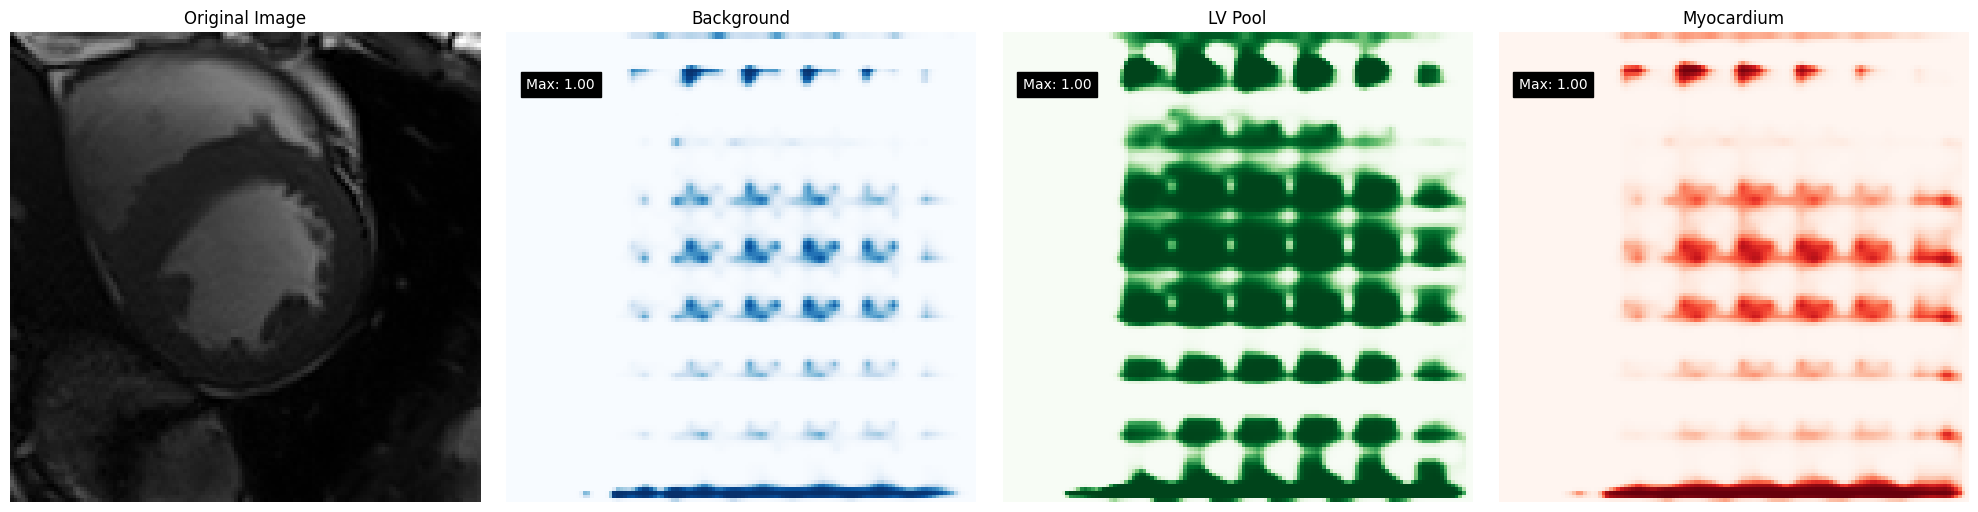

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np



# 1. 确保剥离梯度并转换为概率
# 假设 final_masks 来自模型输出
# 如果 final_masks 是 [1, 3, 128, 128]，先 squeeze(0) 去掉 batch 维度
if final_masks.dim() == 4:
    final_masks = final_masks.squeeze(0)

probs = torch.sigmoid(final_masks).detach().cpu().numpy()

# 此时 probs 应该是 (3, 128, 128)
print(f"可视化数据形状 (Probs Shape): {probs.shape}")

# 2. 获取底图
img_bg = batch_data["image"].squeeze().cpu().numpy()
if img_bg.ndim == 3: # 处理 [3, 1024, 1024]
    img_bg = img_bg[0]

# 3. 绘图配置
labels = ['Background', 'LV Pool', 'Myocardium']
cmaps = ['gray', 'Blues', 'Greens', 'Reds']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 第一张：底图
axes[0].imshow(img_bg, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# 后面三张：循环打印每个类别通道
for i in range(3):
    # 强制确保传入的是 (128, 128)
    channel_data = probs[i].squeeze() 
    
    im = axes[i+1].imshow(channel_data, cmap=cmaps[i+1])
    axes[i+1].set_title(labels[i])
    axes[i+1].axis('off')
    
    # 打印置信度
    max_p = np.max(channel_data)
    axes[i+1].text(5, 15, f"Max: {max_p:.2f}", color='white', 
                   backgroundcolor='black', fontsize=10)

plt.tight_layout()
plt.show()

In [27]:
# ==========================================
# 单元格：定义混合 Loss 函数 (CE + Dice)
# ==========================================
import torch.nn.functional as F

def calc_hybrid_loss(pred_logits, gt_mask, num_classes=3):
    """
    pred_logits: [B, 3, 128, 128]
    gt_mask: [B, 128, 128] (LongTensor)
    """
    # 1. CrossEntropy: 强制像素级分类竞争
    # 给背景类(0)较低权重，给 LV(1) 和 Myo(2) 更高权重，解决激活弥散问题
    weights = torch.tensor([0.2, 1.0, 1.2]).to(pred_logits.device)
    ce_loss = F.cross_entropy(pred_logits, gt_mask, weight=weights)

    # 2. 多类 Dice Loss: 优化形状边界
    pred_probs = F.softmax(pred_logits, dim=1)
    target_oh = F.one_hot(gt_mask, num_classes=num_classes).permute(0, 3, 1, 2).float()
    
    # 忽略背景通道，只算 LV 和 Myo 的 Dice
    dims = (0, 2, 3)
    intersection = torch.sum(pred_probs[:, 1:] * target_oh[:, 1:], dims)
    cardinality = torch.sum(pred_probs[:, 1:] + target_oh[:, 1:], dims)
    dice_loss = 1 - (2. * intersection / (cardinality + 1e-6)).mean()

    return ce_loss + dice_loss

In [28]:
# ==========================================
# 单元格：初始化训练核心组件
# ==========================================
import torch
from torch.cuda.amp import GradScaler

# 1. 实例化混合精度缩放器 (修复 NameError 的关键)
loss_scaler = GradScaler()

# 2. 确保优化器已定义
# 使用 AdamW，并将学习率设为 1e-5 以保证微调的稳定性
optimizer = torch.optim.AdamW(our_model.parameters(), lr=1e-5, weight_decay=0.01)

# 3. 记录设备信息
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Loss Scaler 已就绪，准备在 {device} 上进行 3 分类微调 。")

✅ Loss Scaler 已就绪，准备在 cuda 上进行 3 分类微调 。


In [ ]:
# ==========================================
# 单元格：开启 Fine-tuning (微调)
# ==========================================
RUN_EPOCHS = 30 
loss_history = []

our_model.train()
print(f" 正在进行心脏 3 分类微调训练... ")

for epoch in range(1, RUN_EPOCHS + 1):
    epoch_loss = 0.0
    for step, batch_data in enumerate(dl):
        # A. 搬运数据并生成 BBox 提示
        images = batch_data["image"].to(device)
        gt_masks = batch_data["mask"].squeeze(1).to(device).long()
        
        # 动态生成 Task B.2 要求的正方形 BBox
        batch_prompts = []
        for i in range(images.shape[0]):
            res = ff.get_tilted_3d_bbox(gt_masks[i].cpu().numpy(), padding=10)
            box = torch.tensor(res['sam_prompt']).to(device).unsqueeze(0) if res else None
            batch_prompts.append({
                'image': images[i], 
                'boxes': box, 
                'original_size': (128, 128)
            })

        # B. 混合精度前向传播 (AMP)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = our_model(batch_prompts, multimask_output=True)
            # 提取 3 分类 Logits
            pred_logits = torch.stack([o['masks'] for o in outputs]).squeeze(1)
            loss = calc_hybrid_loss(pred_logits, gt_masks)

        # C. 使用 Scaler 更新梯度 (修正后的标准流程)
        # 1. 首先对缩放后的 loss 进行反向传播
        loss_scaler.scale(loss).backward()
        
        # 2. 然后让 scaler 解放梯度并执行优化器步进
        loss_scaler.step(optimizer)
        
        # 3. 最后更新 scaler 的缩放因子
        loss_scaler.update()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dl)
    loss_history.append(avg_loss)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{RUN_EPOCHS}] | 平均 Loss: {avg_loss:.4f}")

print("✅ 本阶段微调完成。")

🚀 正在进行心脏 3 分类微调训练... 
x shape:  torch.Size([3, 1024, 1024])
input images:  torch.Size([1, 3, 1024, 1024])


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 8.00 GiB total capacity; 18.26 GiB already allocated; 0 bytes free; 18.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Hybrid Loss (CE + Dice)')
plt.title('Fine-tuning Progress: SAM 3-Class Heart Segmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.grid(True)
plt.legend()
plt.show()